In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
dj.config["display.limit"] = 50

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import numpy as np
from mlutils.measures import corr

import matplotlib.pyplot as plt
import seaborn as sns

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nnfabrik.utility.dj_helpers import CustomSchema
schema = CustomSchema(dj.config.get('schema_name', 'nnfabrik_core'))

from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed
from nndichromacy.utility.measures import get_avg_correlations, get_correlations
from nndichromacy.tables.from_nnfabrik import ScoringTable, TrainedModel
from nndichromacy.tables.utility import DataCache, TrainedModelCache, EnsembleModelCache
from nndichromacy.utility.measures import get_avg_correlations, get_correlations

from nndichromacy.tables.scores import TestCorrelation_BlueTestSet, TestCorrelation_GreenTestSet


Connecting kwilleke@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


# Importing Virtual Module, to get ScanSet

In [ ]:
experiment = dj.create_virtual_module('experiment', 'sinzlab_houston_data')


# Selection of Dataset Hashes

In [3]:
dataset_hashes = ['582779f7975715e956c38156b62326a4',
                  'b8e3b04918245ced80e12cb43cd27eb4'
                 ]
seed = 1000

# Plotting Parameters

In [11]:
cmap = sns.blend_palette(['#9b59b6', '#2ecc71',], as_cmap=True)

linewidths = 0.5
corr_color_difference = .2
max_scatter_size = 200
fontsize = 16

# The Plot

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


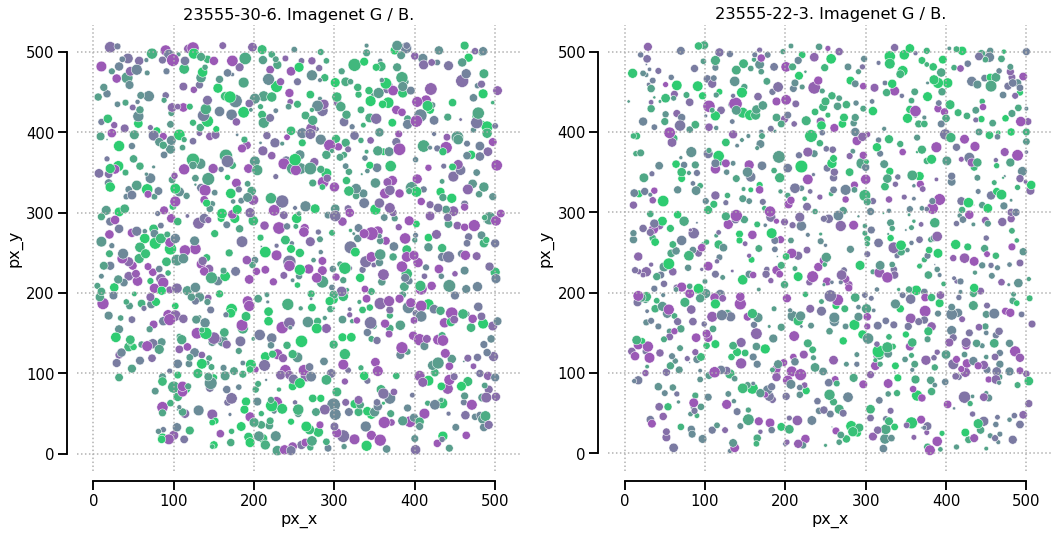

In [14]:
n_columns = len(dataset_hashes)

figure, axs = plt.subplots(1, n_columns, figsize=(15,25))
sns.set_context('talk', font_scale=0.9)

for i, ax in enumerate(axs.ravel()):
    
    dataset_hash = dataset_hashes[i]
    filename = (Dataset&dict(dataset_hash=dataset_hash)).fetch1("dataset_config")["paths"][0]
    scan_key = (PreprocessedMouseData & dict(filename=filename)).fetch("animal_id", "session", "scan_idx", as_dict=True)
    
    score_key = dict(dataset_hash=dataset_hash, seed=seed)
    title = (Dataset&dict(dataset_hash=dataset_hash)).fetch1("dataset_comment")
    
    px_x, px_y, corr_g, corr_b = ((TestCorrelation_GreenTestSet.Units * TestCorrelation_BlueTestSet.Units & score_key)  
                                  * (dj.U("unit_id", "px_x", "px_y") & (experiment.ScanSet().UnitInfo & scan_key))).fetch("px_x", "px_y", "unit_test_correlation_green", "unit_test_correlation_blue")

    color = (corr_g - corr_b)
    max_corr = np.max(np.vstack([corr_g,corr_b]),axis=0)
    size = np.round((max_corr) * max_scatter_size)

    ax.scatter(px_x, px_y, s=size, edgecolors='w', linewidths=linewidths, c=color, cmap=cmap, vmin=-corr_color_difference, vmax=corr_color_difference)
    
    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle=':')
    ax.set_xlabel("px_x", fontsize=fontsize)
    ax.set_ylabel("px_y", fontsize=fontsize)
    ax.set_title(title)

sns.despine(trim=True, offset=10)
plt.tight_layout()

plt.savefig('recording_positions_23555_B_G_scans.pdf', dpi=100, bbox_inches="tight")